<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Hermite Interpolator Tutorial in NRPy 

## Author: Maria C. Babiuc-Hamilton
### Template courtesy Zach Etienne and Brandon Clark

### NRPy+ Source Code for this module: [hermite_interpolator.py](../edit/hermite_interpolator.py)


<a id='toc'></a>

# Table of Contents \[Back to [top](#toc)\]
$$\label{toc}$$ 

This notebook is organized as follows

1. [Hermite1D](#hi1d): Cubic Hermite Interpolation on a 1D Uniform Grid
1. [Hermite2D](#hi2d): Bicubic Hermite Interpolation on a 2D Uniform Grid
1. [Hermite3D](#hi3d): Tricubic Hermite Interpolation on a 3D Uniform Grid

<!-- 
1. [Step 1](#himodule): The Hermite Interpolator NRPy+ module
    1. [Step 1.a](#hicoeffs_func): The `compute_hicoeffs_histencl()` function
        1. [Step 1.a.i](#exercise): Exercise: Using `compute_hicoeffs_histencl()`
    1. [Step 1.b](#hioutputc): The  `HI_outputC()` function
1. [Step 2](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF  
--> 

<a id='hi1d'></a>

# Hermite Interpolation on a 1D Uniform Grid \[Back to [top](#toc)\]
$$\label{hi1d}$$

In this tutorial we will develop a $3^{rd}$ order interpolation technique on uniform grids using the cubic [Hermite interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation) (HI) techniques. 

We will develop the cubic Hermite interpolation on a *uniform* numerical grid.
Let's start in one dimension, for proof of principle, and name the coordinate of that dimension $x$.
Since the grid is uniform, the spacing between successive grid points is constant. Let's denote it $h_{x}=x_{k+1} - x_{k}=const$. 
Then, given a function $f(x)$ on this uniform grid, we will adopt the notation

$$
f(x_k) = f_k, ~
\frac{df(x_k)}{dx} = d_x f_k.
$$

We want to interpolate this function onto a point $(x)$ between the two points: $[x_{k}, x_{k+1}]$.

We will need to add $2$ more points, such that, starting from the left to the right, the stencil is: 
$$[x_{k-1}, x_{k}, x_{k+1}, x_{k+2}]$$
We define the distance from the known point to the interpolating point: 
$$s(x) = x - x_{k} = \xi h_x$$
where $h_x=x_{k+1} - x_{k}$ and $0<\xi<1.$

HI techniques are usually constructed as follows:
We fit a third order smooth polynomial to the function, and *impose smoothnes in the derivative* by fitting the derivative of this smooth polynomial to its derivative at the point $x$:
$$
\begin{array}\\
P(x) & = f(x)  = \sum_{i=0}^3 c_{i} s^i \\
\frac{d}{dx}P(x) & = \frac{df(x)}{dx}  = \sum_{i=1}^3 i c_{i} s^{i-1}
\end{array}
$$

The interpolation problem consists of solving this system, to determe the $4$ unknown coefficients:
$$c_{0}, c_{1}, c_{2}, c_{3}.$$

To accomplish this, we form the system of $4$ equations by writing the above equations at the two edges of the interpolation interbal:
$$
\begin{array}\\
P(x_{k})             & = f_k   = \sum_{i=0}^3 c_{i} s(x_{k})^i \\
P(x_{k+1})           & = f_{k+1} = \sum_{i=0}^3 c_{i} s(x_{k+1})^i \\
\frac{d}{dx}P(x_{k}) & = d_x f_k = \sum_{i=1}^3 i c_{i} s(x_{k})^{i-1} \\
\frac{d}{dx}P(x_{k+1})& = d_x f_{k+1}= \sum_{i=1}^3 i c_{i} s(x_{k+1})^{i-1}
\end{array}
$$
Noting that: $s(x_{k}) = x_{k} - x_{k} = 0$ and $s(x_{k+1}) = x_{k+1} - x_{k} = h_x$, the system of 4 equations with 4 unknowns simplifies to:
$$ 
\left\{
    \begin{array}\\
f_k         &= c_{0}\\
f_{k+1}     &= c_{0} + c_{1}h + c_{2}h^2 + c_{3}h^3\\
d_x f_k     &= c_{1}\\
d_x f_{k+1} &= c_{1} + 2c_{2}h + 3c_{3}h^2
\end{array}
\right.
$$

The key now is to calculate the numerical derivative at the edges such that the function stays smooth, at least locally.
For this, we introduce a quantity called the *first divided difference* on three out of the $4$ points considered for the interpolation: 
$$
\delta x_{k-1} = \frac{f_{k  }-f_{k-1}}{h_x},~
\delta x_{k  } = \frac{f_{k+1}-f_{k  }}{h_x},~
\delta x_{k+1} = \frac{f_{k+2}-f_{k+1}}{h_x}
$$

Next, we define the *second divided difference* as the average of the reciprocals of the *first divided difference*
$$ \frac{1}{d_k} = {\frac{1}{2\delta_{k-1}}+\frac{1}{2\delta_k}}$$
On the points left and right the interpolating point, these become: 
$$
d_{k  } =\frac{2 \delta_{k  } \delta_{k-1}}{\delta_{k  } + \delta_{k-1}},~
d_{k+1} =\frac{2 \delta_{k+1} \delta_{k  }}{\delta_{k+1} + \delta_{k  }}.
$$

Then we impose the condition of smoothness on the derivative of the function. This condition will be written as: 
$$ 
d_x f_{k} = \left\{
\begin{array}\\
0     & \mbox{if } \ \text{sgn}(\delta_{k−1})\neq \text{sgn}(\delta_{k})\\
dx_{k}& \mbox{if } \ \text{sgn}(\delta_{k−1})=\text{sgn}(\delta_{k})
\end{array}
\right.
$$
and
$$ 
d_x f_{k+1} = \left\{
\begin{array}\\
0        & \mbox{if } \ \text{sgn}(\delta_{k})\neq \text{sgn}(\delta_{k+1})\\
dx_{k+1} & \mbox{if } \ \text{sgn}(\delta_{k})=\text{sgn}(\delta_{k+1}).
\end{array}
\right.
$$

It follows that the derivatives of the functions are replaced with:
$$d_x f_{k} = d_k,~d_x f_{k+1} = d_{k+1}.$$

We also substitute 
$$ 
f_{k+1} = f_k + h_x \delta_k,~
s(x) =\xi h_x
$$
to simplify the stepsize $hx$ from the expressions for the Hermite coefficients. 
Now we form the interpolation polynomial again:
$$
f(x) = P(x) = \sum_{i=0}^3 c_i s^i = \sum_{i=0}^3 C_i \xi^i
$$ 
where where $c_i h^i = C_i$.
The final form of the 1D Hermite coefficients is:
$$
\begin{array} \\
C_0 &= f_k \\
C_1 &= h_x d_k\\
C_2 &=  h_x(-2 d_k - d_{k+1} + 3 \delta_k)\\
C_3 &= h_x(d_k + d_{k+1} - 2 \delta_k).
\end{array}
$$
**The algorithm is simple: we compute $(f_k, \delta_k, d_k)$ at each point on the grid, impose the continuity condition, and then compute the coefficients $C_i$.** 

Let's solve the system in *python* to find these coefficients.
We use: https://scaron.info/blog/solving-symbolic-equations-with-sympy.html https://problemsolvingwithpython.com/10-Symbolic-Math/10.03-Defining-Variables/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html
There are many ways to solve the system and compute the coefficients. Below we implement an approach that solves directly for $C_i$ imposing also conditions on the derivatives.

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
#from scipy.optimize import fsolve

In [88]:
# define the variables
hx = sym.var('hx')
c0, c1, c2, c3 = sym.var('c0 c1 c2 c3') 
fk, fkp1, dxfk, dxfkp1 = sym.var('fk fkp1 dxfk dxfkp1') 
delk, dk, dkp1 = sym.var('delk dk dkp1') 
C0, C1, C2, C3 = sym.symbols('C0 C1 C2 C3')
fkp1 = fk + hx*delk
#dxfk = dk
#dxfkp1 = dkp1
c0 = C0
c1 = C1/hx
c2 = C2/(hx**2)
c3 = C3/(hx**3)
#Define the equations
E0 = sym.Eq(c0, fk)
E1 = sym.Eq(c0 + c1*hx + c2*hx**2 + c3*hx**3,fkp1)
E2 = sym.Eq(c1,dxfk)
E3 = sym.Eq(c1 +2* c2*hx + 3*c3*hx**2,dxfkp1)

#Solve
sols=sym.solve([E0, E1, E2, E3], [C0, C1, C2, C3])
C0 = sols[C0].factor()
C1 = sols[C1].factor()
C2 = sols[C2].factor()
C3 = sols[C3].factor()

print ("C0 = ", C0)
print ("C1 = ", C1)
print ("C2 = ", C2)
print ("C3 = ", C3)


print ("c0 = ", (C0/(hx**0)).factor())
print ("c1 = ", (C1/(hx**1)).factor())
print ("c2 = ", (C2/(hx**2)).factor())
print ("c3 = ", (C3/(hx**3)).factor())

C0 =  fk
C1 =  dxfk*hx
C2 =  hx*(3*delk - 2*dxfk - dxfkp1)
C3 =  -hx*(2*delk - dxfk - dxfkp1)
c0 =  fk
c1 =  dxfk
c2 =  (3*delk - 2*dxfk - dxfkp1)/hx
c3 =  -(2*delk - dxfk - dxfkp1)/hx**2


In [89]:
# write the solutions in readable form
print ("\\begin{array} \\\\")
print ("C_0 & = %s\\\\" % sym.latex(C0))
print ("C_1 & = %s\\\\" % sym.latex(C1))
print ("C_2 & = %s\\\\" % sym.latex(C2))
print ("C_3 & = %s"     % sym.latex(C3))
print ("\\end{array}")

\begin{array} \\
C_0 & = fk\\
C_1 & = dxfk hx\\
C_2 & = hx \left(3 delk - 2 dxfk - dxfkp_{1}\right)\\
C_3 & = - hx \left(2 delk - dxfk - dxfkp_{1}\right)
\end{array}


\begin{array} \\
C_0 & = f_k\\
C_1 & = d_x f_k h_x\\
C_2 & = h_x(3 \delta_k - 2 d_x f_k  - d_x f_{k+1})\\
C_3 & = -h_x(2 \delta_k - d_x f_k h_x - d_x f_{k+1})
\end{array}

In [55]:
#another approach, used as sanity check
hx = sym.var('hx')
ci = sym.Matrix([[1,0,0,0],[1,hx,hx**2,hx**3],[0,1,0,0],[0,1, 2*hx,3*hx**2,]])
F = sym.Matrix([fk, fk + hx*delk, dk, dkp1])
sym.pprint(ci)
sym.pprint(ci.inv()*F)

⎡1  0    0      0  ⎤
⎢                  ⎥
⎢         2      3 ⎥
⎢1  hx  hx     hx  ⎥
⎢                  ⎥
⎢0  1    0      0  ⎥
⎢                  ⎥
⎢                 2⎥
⎣0  1   2⋅hx  3⋅hx ⎦
⎡                  fk                   ⎤
⎢                                       ⎥
⎢                  dk                   ⎥
⎢                                       ⎥
⎢  2⋅dk   dkp₁   3⋅fk   3⋅(delk⋅hx + fk)⎥
⎢- ──── - ──── - ──── + ────────────────⎥
⎢   hx     hx      2            2       ⎥
⎢                hx           hx        ⎥
⎢                                       ⎥
⎢  dk   dkp₁   2⋅fk   2⋅(delk⋅hx + fk)  ⎥
⎢ ─── + ──── + ──── - ────────────────  ⎥
⎢   2     2      3            3         ⎥
⎣ hx    hx     hx           hx          ⎦


In [56]:
solM = ci.LUsolve(F)
c0 = sym.pprint(solM[0].factor())
c1 = sym.pprint(solM[1].factor())
c2 = sym.pprint(solM[2].factor())
c3 = sym.pprint(solM[3].factor())

fk
dk
3⋅delk - 2⋅dk - dkp₁
────────────────────
         hx         
-(2⋅delk - dk - dkp₁) 
──────────────────────
           2          
         hx           


Now let's test our interpolator. We will pick a 1D function of the form:
$$
f(x) = x \sin(x).
$$
Then we impose the condition of smoothness on the derivative of the function. 

In [90]:
# testing the 1D Hermite interpolator

#calculate the smooth derivatives
def smooth_df_1D(hx, fkp2, fkp1, fk, fkm1):
    # first, calculate the first divided difference
    delxkm1 = (fk - fkm1)/(hx)
    delxk   = (fkp1 - fk)/(hx)
    delxkp1  = (fkp2 - fkp1)/(hx)
    # then calculate the slope
    dxk =(2.*delxk*delxkm1)/(delxk + delxkm1)
    dxkp1 =(2.*delxkp1*delxk)/(delxkp1 + delxk)
    # lastly, impose the condition on derivatives
    if np.sign(delxkm1) == np.sign(delxk):
        dxfk = dxk
    else:
        dxfk = 0
    if np.sign(delxk) == np.sign(delxkp1):
        dxfkp1 = dxkp1
    else:
        dxfkp1 = 0
    return delxk, dxfk, dxfkp1

#calculate the Hermite c0efficients

def Hermite_1D_coeffs(hx, fk, delxk, dxfk, dxfkp1):
    C0 =  fk
    C1 =  dxfk*hx
    C2 =  hx*(3*delxk - 2*dxfk - dxfkp1)
    C3 = -hx*(2*delxk - dxfk - dxfkp1)
    return C0, C1, C2, C3 

In [91]:
# check convergence
import numpy as np
# create a grid of 100 and 200 points  
# check the convergence!
xc = np.linspace(-5,5,101) #coarse grid
xr = np.linspace(-5,5,201) #refined grid

# the exact functions
fc = xc*np.sin(xc)
fr = xr*np.sin(xr)
# the refinement
hc = xc[1]-xc[0]
hr = xr[1]-xr[0]
# the desired interpolation location
xi = 1/2
# the position of the interpolation point
xc_xi = xc + hc*xi
xr_xi = xr + hr*xi

# the exact function
yc_exact = xc_xi*np.sin(xc_xi)
yr_exact = xr_xi*np.sin(xr_xi)

finterpc = []

#call the interpolator on the coarse grid
for i in range(1,len(xc)-2):
    fkp2c = fc[i+2] 
    fkp1c = fc[i+1] 
    fkc = fc[i] 
    fkm1c = fc[i-1]
    #calculate the smoothness condition and the coefficients
    delxkc, dxfkc, dxfkp1c = smooth_df_1D(hc, fkp2c, fkp1c, fkc, fkm1c)
    C0c, C1c, C2c, C3c = Hermite_1D_coeffs(hc, fkc, delxkc, dxfkc, dxfkp1c)
    fintc = C0c + C1c*xi + C2c*xi**2  + C3c*xi**3
    finterpc.append(fintc)

# to plot the interpolated function agains the exact function, we must add the boundary points
finterpc = np.asarray(finterpc)    
yc_interp = np.concatenate([[yc_exact[0]],finterpc,[yc_exact[len(xc)-2]],[yc_exact[len(xc)-1]]])


finterpr = []

#call the interpolator on the coarse grid
for i in range(1,len(xr)-2):
    fkp2r = fr[i+2] 
    fkp1r = fr[i+1] 
    fkr = fr[i] 
    fkm1r = fr[i-1]
    #calculate the smoothness condition and the coefficients
    delxkr, dxfkr, dxfkp1r = smooth_df_1D(hr, fkp2r, fkp1r, fkr, fkm1r)
    C0r, C1r, C2r, C3r = Hermite_1D_coeffs(hr, fkr, delxkr, dxfkr, dxfkp1r)
    fintr = C0r + C1r*xi + C2r*xi**2  + C3r*xi**3
    finterpr.append(fintr)

# to plot the interpolated function agains the exact function, we must add the boundary points
finterpr = np.asarray(finterpr)    
yr_interp = np.concatenate([[yr_exact[0]],finterpr,[yr_exact[len(xr)-2]],[yr_exact[len(xr)-1]]])

print(len(yc_interp),len(yr_interp))

101 201


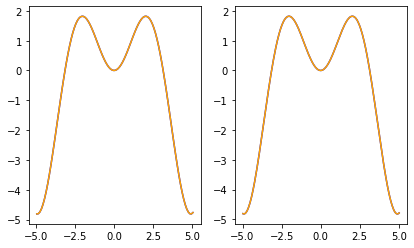

<Figure size 720x720 with 0 Axes>

In [92]:
# plotting
import matplotlib.pyplot as plt

fig = plt.figure()
plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# plot the coarse functions
ax1.plot(xc_xi,yc_exact, color ='blue', label='Coarse grid function')
ax1.plot(xc_xi,yc_interp, color ='orange', label='Coarse exact function')

ax2 = fig.add_subplot(1,2,2)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
# plot the refined functions
ax2.plot(xr_xi,yr_exact, color ='blue', label='Refined grid function')
ax2.plot(xr_xi,yr_interp, color ='orange', label='Refined exact function')

fig.subplots_adjust(left=None, bottom=None, right=1, top=None, wspace=None, hspace=None)
#fig.tight_layout()
plt.show()

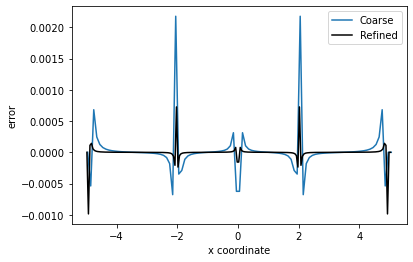

In [93]:
# error budget
plt.plot(xc_xi,(yc_exact-yc_interp), linewidth=1.5, label='Coarse')
plt.legend()
plt.plot(xr_xi,(yr_exact-yr_interp), linewidth=1.5, color='black', label='Refined')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('error')
#plt.yscale('log')
plt.show()

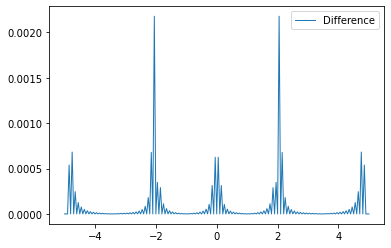

In [94]:
#Stack the two coarse arrays to compare with the refined one
fc_stack = np.dstack((fc,yc_interp)).flatten()
last = len(fc_stack)-1
# Removing the last element using slicing 
fc_stack = fc_stack[:last]
len(fc_stack)

plt.plot(xr,abs(fc_stack - fr), linewidth=1, label='Difference')
plt.legend()
#plt.plot(xr_xi,(fc_stack - fr), linewidth=2, label='Difference')
#plt.legend()
plt.show()

<a id='hi2d'></a>

# Hermite Interpolation on a 2D Uniform Grid \[Back to [top](#toc)\]
$$\label{hi2d}$$

A *bicubic* Hermite interpolation extends the 1D cubic interpolation to a 2D grid. 

We consider a stencil of $4\times 4=16$ known points, on a uniform 2D grid, starting from the lower left corner us, and then advancing right: 


$$
[x_{k-1},y_{k-1}, x_{k-1},y_{k}, x_{k-1},y_{k+1}, x_{k-1},y_{k+2}, \\
 x_{k  },y_{k-1}, x_{k  },y_{k}, x_{k  },y_{k+1}, x_{k  },y_{k+2}, \\
 x_{k+1},y_{k-1}, x_{k+1},y_{k}, x_{k+1},y_{k+1}, x_{k+1},y_{k+2}, \\
 x_{k+1},y_{k-1}, x_{k+2},y_{k}, x_{k+2},y_{k+1}, x_{k+2},y_{k+1}] .
$$

We interpolate onto the 2D point $(x,y)$ in the middle of the rectangle formed by the $4$ corners starting lower-left and going counterclockwise: 
$$
[x_{k  },y_{k  }, x_{k  },y_{k+1},\\
 x_{k+1},y_{k+1}, x_{k+1},y_{k  }].
 $$

The Hermite interpolator is:
$$P(x,y) = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x^i s_y^j,$$
where $s_x$ is the distance in the $x$ direction from the point of interpolation $(x,y)$ to $x_k$, namely: 
$$s_x(x) = x - x_k = \xi h_x  $$
and $s_y$ is the distance in the $y$ direction from point of interpolation $(x,y)$ to $y_k$: 
$$s_y(y) = y - y_k = \mu h_y.$$

We now form the system of $16$ equations with 16 unknowns. We have $4$ equations for the corners:
$$
\begin{array} \\
P(x_{k  },y_{k  }) &= f_{k  ,k  } = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k  })^i s_y(y_{k  })^j,\\
P(x_{k  },y_{k+1}) &= f_{k  ,k+1} = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k  })^i s_y(y_{k+1})^j\\
P(x_{k+1},y_{k+1}) &= f_{k+1,k+1} = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k+1})^i s_y(y_{k+1})^j\\
P(x_{k+1},y_{k  }) &= f_{k+1,k  } = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k+1})^i s_y(y_{k  })^j
\end{array}
$$

Next we have $4$ equations for the $x$ derivative at the $4$ corners:
$$
\begin{array} \\
\frac{d}{dx}P(x_{k  },y_{k  }) & = d_x f_{k  ,k  } = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k  })^j\\
\frac{d}{dx}P(x_{k  },y_{k+1}) & = d_x f_{k  ,k+1} = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k+1})^j\\
\frac{d}{dx}P(x_{k+1},y_{k+1}) & = d_x f_{k+1,k+1} = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k+1})^j\\
\frac{d}{dx}P(x_{k+1},y_{k  }) & = d_x f_{k+1,k  } = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k  })^j
\end{array}
$$

We are adding now $4$ equations for the $y$ derivative at the $4$ corners:
$$
\begin{array} \\
\frac{d}{dy}P(x_{k  },y_{k  }) & = d_y f_{k  ,k  } = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k  })^{i} s_y(y_{k  })^{j-1} \\
\frac{d}{dy}P(x_{k  },y_{k+1}) & = d_y f_{k  ,k+1} = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k  })^{i} s_y(y_{k+1})^{j-1} \\
\frac{d}{dy}P(x_{k+1},y_{k+1}) & = d_y f_{k+1,k+1} = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k+1})^{i} s_y(y_{k+1})^{j-1} \\
\frac{d}{dy}P(x_{k+1},y_{k  }) & = d_y f_{k+1,k  } = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k+1})^{i} s_y(y_{k  })^{j-1}
\end{array}
$$


Up to now we have $12$ equations. The last $4$ equations are obtained by adding to this the mixed derivatives: 
$\frac{d^2}{dxdy}P(x,y) = f_{xy} = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} s_x^{i-1} s_y^{j-1}$, which becomes at the $4$ corners:

$$
\begin{array} \\
\frac{d^2}{dxdy}P(x_{k  },y_{k  }) & = d_{xy} f_{k  ,k  } = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k  })^{j-1}\\
\frac{d^2}{dxdy}P(x_{k  },y_{k+1}) & = d_{xy} f_{k  ,k+1} = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j-1}\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k+1}) & = d_{xy} f_{k+1,k+1} = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j-1}\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k  }) & = d_{xy} f_{k+1,k  } = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j-1}
\end{array}
$$


In [95]:
import sympy as sym
# define the variables
hx, hy = sym.var('hx, hy')
x, y, xk, yk = sym.var('x, y, xk, yk')
c00, c01, c02, c03 = sym.var('c00 c01 c02 c03') 
c10, c11, c12, c13 = sym.var('c10 c11 c12 c13') 
c20, c21, c22, c23 = sym.var('c20 c21 c22 c23') 
c30, c31, c32, c33 = sym.var('c30 c31 c32 c33') 

fkk, fkkp1, fkp1kp1, fkp1k         = sym.symbols('fkk fkkp1 fkp1kp1 fkp1k')
dxfkk, dxfkkp1, dxfkp1kp1, dxfkp1k = sym.symbols('dxfkk dxfkkp1 dxfkp1kp1 dxfkp1k')
dyfkk, dyfkkp1, dyfkp1kp1, dyfkp1k = sym.symbols('dyfkk dyfkkp1 dyfkp1kp1 dyfkp1k')
dxyfkk, dxyfkkp1, dxyfkp1kp1, dxyfkp1k = sym.symbols('dxyfkk dxyfkkp1 dxyfkp1kp1 dxyfkp1k')

In [96]:
# introduce the conditions on the derivatives
delxkk, delykk, delykp1k           = sym.symbols('delxkk delykk delykp1k') 

fkp1k = fkk + hx*delxkk
fkkp1 = fkk + hy*delykk
fkp1kp1 = fkk + hx*delxkk + hy*delykp1k

In [97]:
# define the sums that enter in the equations to be solved
sx = x - xk
sy = y - yk
i, j = sym.var('i j')
cij = sym.Matrix([[c00, c01, c02, c03],[c10, c11, c12, c13],
                  [c20, c21, c22, c23],[c30, c31, c32, c33]])
#sym.pprint(cij)

Sum01 = sym.summation(cij[i, j]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 3))
Sum02 = sym.summation(cij[i, j]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 3)) 
Sum03 = sym.summation(cij[i, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 3))
Sum04 = sym.summation(cij[i, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 3)) 

Sum05 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 2))
Sum06 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 2)) 
Sum07 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 2)) 
Sum08 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 2))

Sum09 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 3))
Sum10 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 3))
Sum11 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 3))
Sum12 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 3))

Sum13 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 2))
Sum14 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 2))
Sum15 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 2))
Sum16 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 2))

#print ("Sum33 = ", Sum33)

In [98]:
#Define the equations
E01 = sym.Eq(Sum01.factor(),fkk)
E02 = sym.Eq(Sum02.factor(),fkkp1)
E03 = sym.Eq(Sum03.factor(),fkp1kp1)
E04 = sym.Eq(Sum04.factor(),fkp1k)

E05 = sym.Eq(Sum05.factor(),dxfkk)
E06 = sym.Eq(Sum06.factor(),dxfkkp1)
E07 = sym.Eq(Sum07.factor(),dxfkp1kp1)
E08 = sym.Eq(Sum08.factor(),dxfkp1k)

E09 = sym.Eq(Sum09.factor(),dyfkk)
E10 = sym.Eq(Sum10.factor(),dyfkkp1)
E11 = sym.Eq(Sum11.factor(),dyfkp1kp1)
E12 = sym.Eq(Sum12.factor(),dyfkp1k)

E13 = sym.Eq(Sum13.factor(),dxyfkk)
E14 = sym.Eq(Sum14.factor(),dxyfkkp1)
E15 = sym.Eq(Sum15.factor(),dxyfkp1kp1)
E16 = sym.Eq(Sum16.factor(),dxyfkp1k)

#print(E33)

#solve the system
sols2D = sym.solve([E01,E02,E03,E04, E05,E06,E07,E08, 
                    E09,E10,E11,E12, E13,E14,E15,E16], [c00,c01,c02,c03, c10,c11,c12,c13, c20,c21,c22,c23, c30,c31,c32,c33])

cijsols = sym.Matrix([[sols2D[c00].factor(), sols2D[c01].factor(), sols2D[c02].factor(), sols2D[c03].factor()],
                      [sols2D[c10].factor(), sols2D[c11].factor(), sols2D[c12].factor(), sols2D[c13].factor()],
                      [sols2D[c20].factor(), sols2D[c21].factor(), sols2D[c22].factor(), sols2D[c23].factor()],
                      [sols2D[c30].factor(), sols2D[c31].factor(), sols2D[c32].factor(), sols2D[c33].factor()]])
Cijsols = sym.Matrix([[cijsols[0,0],         cijsols[0,1]*(hy),         cijsols[0,2]*(hy**2),         cijsols[0,3]*(hy**3)],
                      [cijsols[1,0]*(hx),    cijsols[1,1]*(hx)*(hy),    cijsols[1,2]*(hx)*(hy**2),    cijsols[1,3]*(hx)*(hy**3)],
                      [cijsols[2,0]*(hx**2), cijsols[2,1]*(hx**2)*(hy), cijsols[2,2]*(hx**2)*(hy**2), cijsols[2,3]*(hx**2)*(hy**3)],
                      [cijsols[3,0]*(hx**3), cijsols[3,1]*(hx**3)*(hy), cijsols[3,2]*(hx**3)*(hy**2), cijsols[3,3]*(hx**3)*(hy**3)]])

In [99]:
print("c20 = ",cijsols[2,0])
print("C20 = ",Cijsols[2,0])
print("C2 = ",C2)
#PSum12 = sym.Poly(Sum12, c00,c01,c02,c03, c10,c11,c12,c13, 
#                         c20,c21,c22,c23, c30,c31,c32,c33)
#PSum12.as_expr().as_coefficients_dict()
#CSum02 = PSum02.coeffs()
#MSum02 = PSum02.monoms()
#MCSum02 = sym.Matrix(CSum02)
#MMSum02 = sym.Matrix(MSum02)
#sym.pprint(MCSum02.T*MMSum02)
#sym.pprint(MCSum02.T)
#print(PSum02)

c20 =  (3*delxkk - 2*dxfkk - dxfkp1k)/hx
C20 =  hx*(3*delxkk - 2*dxfkk - dxfkp1k)
C2 =  hx*(3*delk - 2*dxfk - dxfkp1)


In [100]:
# testing the 2D Hermite interpolator

#calculate the smooth derivatives
def smooth_df_2D(hx, hy, 
                fkp2kp2, fkp1kp2, fkkp2, fkm1kp2,
                fkp2kp1, fkp1kp1, fkkp1, fkm1kp1,
                fkp2k  , fkp1k  , fkk  , fkm1k  ,
                fkp2km1, fkp1km1, fkkm1, fkm1km1):
    # first, calculate the first divided difference
    
    delxkm1k = (fkk - fkm1k)/(hx)
    delxkk   = (fkp1k - fkk)/(hx)
    delxkp1k = (fkp2k - fkp1k)/(hx)
    
    delxkm1kp1 = (fkkp1 - fkm1kp1)/(hx)
    delxkkp1   = (fkp1kp1 - fkkp1)/(hx)
    delxkp1kp1 = (fkp2kp1 - fkp1kp1)/(hx)
    
    delykkm1 = (fkk - fkkm1)/(hy)
    delykk   = (fkkp1 - fkk)/(hy)
    delykkp1 = (fkkp2 - fkkp1)/(hy)
    
    delykp1km1 = (fkp1k - fkp1km1)/(hy)
    delykp1k   = (fkp1kp1 - fkp1k)/(hy)
    delykp1kp1 = (fkp1kp2 - fkp1kp1)/(hy)
    
    # then calculate the slope
    dxkk  = (2.*delxkk*delxkm1k)/(delxkk + delxkm1k)
    dxkkp1 = (2.*delxkkp1*delxkm1kp1)/(delxkkp1 + delxkm1kp1)
    dxkp1kp1 = (2.*delxkp1kp1*delxkkp1)/(delxkp1kp1 + delxkkp1)
    dxkp1k = (2.*delxkp1k*delxkk)/(delxkp1k + delxkk)
    
    dykk  = (2.*delykk*delykkm1)/(delykk + delykkm1)
    dykkp1 = (2.*delykkp1*delykk)/(delykkp1 + delykkp1)
    dykp1kp1 = (2.*delykp1kp1*delykp1k)/(delykp1kp1 + delykp1k)
    dykp1k = (2.*delykp1k*delykp1km1)/(delykp1k + delykp1km1)
    #TODO
    dxykk = 0
    dxykkp1 = 0
    dxykp1kp1 = 0
    dxykp1k = 0
    
    # impose the condition on derivatives on x
    if np.sign(delxkm1k) == np.sign(delxkk):
        dxfkk = dxkk
    else:
        dxfkk = 0
    if np.sign(delxkk) == np.sign(delxkp1k):
        dxfkp1k = dxkp1k
    else:
        dxfkp1k = 0
        
    if np.sign(delxkm1kp1) == np.sign(delxkkp1):
        dxfkkp1 = dxkkp1
    else:
        dxfkkp1 = 0
    if np.sign(delxkkp1) == np.sign(delxkp1kp1):
        dxfkp1kp1 = dxkp1kp1
    else:
        dxfkp1kp1 = 0    
        
        # impose the condition on derivatives on y
    if np.sign(delykkm1) == np.sign(delykk):
        dyfkk = dykk
    else:
        dyfkk = 0
    if np.sign(delykk) == np.sign(delykkp1):
        dyfkkp1 = dykkp1
    else:
        dyfkkp1 = 0
        
    if np.sign(delykp1km1) == np.sign(delykp1k):
        dyfkp1k = dykp1k
    else:
        dyfkp1k = 0
    if np.sign(delykp1k) == np.sign(delykp1kp1):
        dyfkp1kp1 = dykp1kp1
    else:
        dyfkp1kp1 = 0    
        
    return delxkk, delykk, delykp1k, dxfkk, dxfkp1k, dxfkkp1, dxfkp1kp1, dyfkk, dyfkkp1, dyfkp1k, dyfkp1kp1, dxyfkk, dxyfkkp1, dxyfkp1k, dxyfkp1kp1   

#calculate the Hermite c0efficients
#TODO
def Hermite_2D_coeffs(hx, fk, delxk, dxfk, dxfkp1):
    C00 = fkk
    C01 = dyfkk*hy
    C02 = hy*(3*delykk - 2*dyfkk - dyfkkp1)
    C03 = -hy*(2*delykk - dyfkk - dyfkkp1)
    
    C10 = dxfkk*hx
    C11 = dxyfkk*hx*hy
    C12 = -hx*(3*dxfkk - 3*dxfkkp1 + 2*dxyfkk*hy + dxyfkkp1*hy)
    C13 = hx*(2*dxfkk - 2*dxfkkp1 + dxyfkk*hy + dxyfkkp1*hy)
    
    C20 = hx*(3*delxkk - 2*dxfkk - dxfkp1k)
    C21 = hy*(-2*dxyfkk*hx - dxyfkp1k*hx - 3*dyfkk + 3*dyfkp1k)
    C22 = hx*hy*(4*dxyfkk + 2*dxyfkkp1 + 2*dxyfkp1k + dxyfkp1kp1) 
        + hx*(6*dxfkk - 6*dxfkkp1 + 3*dxfkp1k - 3*dxfkp1kp1) 
        + hy*(-9*delykk + 9*delykp1k + 6*dyfkk + 3*dyfkkp1 - 6*dyfkp1k - 3*dyfkp1kp1)
    C23 = hx*hy*(-2*dxyfkk - 2*dxyfkkp1 - dxyfkp1k - dxyfkp1kp1) 
        + hx*(-4*dxfkk + 4*dxfkkp1 - 2*dxfkp1k + 2*dxfkp1kp1) 
        + hy*(6*delykk - 6*delykp1k - 3*dyfkk - 3*dyfkkp1 + 3*dyfkp1k + 3*dyfkp1kp1)
    
    C30 = -hx*(2*delxkk - dxfkk - dxfkp1k)
    C31 = hy*(2*dyfkk - 2*dyfkp1k + hx*(dxyfkk + dxyfkp1k))
    C32 = hx*hy*(-2*dxyfkk - dxyfkkp1 - 2*dxyfkp1k - dxyfkp1kp1) 
        + hx*(-3*dxfkk + 3*dxfkkp1 - 3*dxfkp1k + 3*dxfkp1kp1) 
        + hy*(6*delykk - 6*delykp1k - 4*dyfkk - 2*dyfkkp1 + 4*dyfkp1k + 2*dyfkp1kp1)
    C33 = hx*hy*(dxyfkk + dxyfkkp1 + dxyfkp1k + dxyfkp1kp1) 
        + hx*(2*dxfkk - 2*dxfkkp1 + 2*dxfkp1k - 2*dxfkp1kp1) 
        + hy*(-4*delykk + 4*delykp1k + 2*dyfkk + 2*dyfkkp1 - 2*dyfkp1k - 2*dyfkp1kp1)
    
    return C00, C01, C02, C03, C10, C11, C12, C13, C20, C21, C22, C23, C30, C31, C32, C33 

In [128]:
#print(sym.collect(Cijsols[3,3],(hx,hy, hx*hy)))

<a id='hi3d'></a>

# Hermite Interpolation on a 3D Uniform Grid \[Back to [top](#toc)\]
$$\label{hi2d}$$

A *tricubic* Hermite interpolation extends the 2D cubic interpolation to a 3D grid. 

We consider a stencil of $4\times 4 \times 4=64$ known points, on a uniform 3D grid

We interpolate onto the 3D point $(x,y,z)$ in the middle of the cube formed by the $8$ corners starting lower-left and going counterclockwise: 
$$(x_{k},y_{k},z_{k}), (x_{k},y_{k+1},z_{k}),(x_{k+1},y_{k+1},z_{k}), (x_{k+1},y_{k},z_{k})\\
(x_{k},y_{k},z_{k+1}), (x_{k},y_{k+1},z_{k+1}),(x_{k+1},y_{k+1},z_{k+1}), (x_{k+1},y_{k},z_{k+1}).$$

The interpolation problem consists of determining the 64 coefficients:
$ c_{ijl} $ for $ i, j, l = (0, 3).$

The Hermite interpolator is:
$$P(x,y) = \sum_{i=0}^3 \sum_{j=0}^3 \sum_{k=0}^3 c_{ijk} s_x^i s_y^j s_z^k,$$
where 
$$
s_x(x) = x - x_k = \xi h_x~,
s_y(y) = y - y_k = \mu h_y~,
s_z(z) = z - z_k = \zeta h_z.
$$

We now form the system of $64$ equations with 64 unknowns. We have $8$ equations for the corners:
$$
\begin{array} \\
P(x_{k  },y_{k  },z_{k  }) & =  f_{k  ,k  ,k  } =  
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k  })^i s_y(y_{k  })^j s_z(z_{k  })^l\\
P(x_{k  },y_{k+1},z_{k  }) & =  f_{k  ,k+1,k  } =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k  })^i s_y(y_{k+1})^j s_z(z_{k  })^l\\
P(x_{k+1},y_{k+1},z_{k  }) & =  f_{k+1,k+1,k  } =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k+1})^i s_y(y_{k+1})^j s_z(z_{k  })^l\\
P(x_{k+1},y_{k  },z_{k  }) & =  f_{k+1,k  ,k  } =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k+1})^i s_y(y_{k  })^j s_z(z_{k  })^l\\
P(x_{k  },y_{k  },z_{k+1}) & =  f_{k  ,k  ,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k  })^i s_y(y_{k  })^j s_z(z_{k+1})^l\\
P(x_{k  },y_{k+1},z_{k+1}) & =  f_{k  ,k+1,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k  })^i s_y(y_{k+1})^j s_z(z_{k+1})^l\\
P(x_{k+1},y_{k+1},z_{k+1}) & =  f_{k+1,k+1,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k+1})^i s_y(y_{k+1})^j s_z(z_{k+1})^l\\
P(x_{k+1},y_{k  },z_{k+1}) & =  f_{k+1,k  ,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 c_{ijl} s_x(x_{k+1})^i s_y(y_{k  })^j s_z(z_{k+1})^l
\end{array}
$$

Next we have $8$ equations for the $x$ derivative at the $8$ corners:
$$
\begin{array} \\
\frac{d}{dx}P(x_{k  },y_{k  },z_{k  }) & =  d_x f_{k  ,k  ,k  } =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^j s_z(z_{k  })^l\\
\frac{d}{dx}P(x_{k  },y_{k+1},z_{k  }) & =  d_x f_{k  ,k+1,k  } =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^j s_z(z_{k  })^l\\
\frac{d}{dx}P(x_{k+1},y_{k+1},z_{k  }) & =  d_x f_{k+1,k+1,k  } =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^j s_z(z_{k  })^l\\
\frac{d}{dx}P(x_{k+1},y_{k  },z_{k  }) & =  d_x f_{k+1,k  ,k  } =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^j s_z(z_{k  })^l\\
\frac{d}{dx}P(x_{k  },y_{k  },z_{k+1}) & =  d_x f_{k  ,k  ,k+1} =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^j s_z(z_{k+1})^l\\
\frac{d}{dx}P(x_{k  },y_{k+1},z_{k+1}) & =  d_x f_{k  ,k+1,k+1} =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^j s_z(z_{k+1})^l\\
\frac{d}{dx}P(x_{k+1},y_{k+1},z_{k+1}) & =  d_x f_{k+1,k+1,k+1} =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^j s_z(z_{k+1})^l\\
\frac{d}{dx}P(x_{k+1},y_{k  },z_{k+1}) & =  d_x f_{k+1,k  ,k+1} =
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 0}^3 i c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^j s_z(z_{k+1})^l
\end{array}
$$

We are adding now $8$ equations for the $y$ derivative at the $8$ corners:
$$
\begin{array} \\
\frac{d}{dy}P(x_{k  },y_{k  },z_{k  }) & =  d_y f_{k  ,k  ,k  } =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k  })^{i} s_y(y_{k  })^{j-1} s_z(z_{k  })^l\\
\frac{d}{dy}P(x_{k  },y_{k+1},z_{k  }) & =  d_y f_{k  ,k+1,k  } =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k  })^{i} s_y(y_{k+1})^{j-1} s_z(z_{k  })^l\\
\frac{d}{dy}P(x_{k+1},y_{k+1},z_{k  }) & =  d_y f_{k+1,k+1,k  } =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k+1})^{j-1} s_z(z_{k  })^l\\
\frac{d}{dy}P(x_{k+1},y_{k  },z_{k  }) & =  d_y f_{k+1,k  ,k  } =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k  })^{j-1} s_z(z_{k  })^l\\
\frac{d}{dy}P(x_{k  },y_{k  },z_{k+1}) & =  d_y f_{k  ,k  ,k+1} =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k  })^{i} s_y(y_{k  })^{j-1} s_z(z_{k+1})^l\\
\frac{d}{dy}P(x_{k  },y_{k+1},z_{k+1}) & =  d_y f_{k  ,k+1,k+1} =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k  })^{i} s_y(y_{k+1})^{j-1} s_z(z_{k+1})^l\\
\frac{d}{dy}P(x_{k+1},y_{k+1},z_{k+1}) & =  d_y f_{k+1,k+1,k+1} =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k+1})^{j-1} s_z(z_{k+1})^l\\
\frac{d}{dy}P(x_{k+1},y_{k  },z_{k+1}) & =  d_y f_{k+1,k  ,k+1} =
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 j c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k  })^{j-1} s_z(z_{k+1})^l
\end{array}
$$

We supplement with the $8$ equations for the $z$ derivative at the $8$ corners:
$$
\begin{array} \\
\frac{d}{dz}P(x_{k  },y_{k  },z_{k  }) & =  d_z f_{k  ,k  ,k  } =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k  })^{i} s_y(y_{k  })^{j} s_z(z_{k  })^{l-1}\\
\frac{d}{dz}P(x_{k  },y_{k+1},z_{k  }) & =  d_z f_{k  ,k+1,k  } =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k  })^{i} s_y(y_{k+1})^{j} s_z(z_{k  })^{l-1}\\
\frac{d}{dz}P(x_{k+1},y_{k+1},z_{k  }) & =  d_z f_{k+1,k+1,k  } =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k+1})^{j} s_z(z_{k  })^{l-1}\\
\frac{d}{dz}P(x_{k+1},y_{k  },z_{k  }) & =  d_z f_{k+1,k  ,k  } =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k  })^{j} s_z(z_{k  })^{l-1}\\
\frac{d}{dz}P(x_{k  },y_{k  },z_{k+1}) & =  d_z f_{k  ,k  ,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k  })^{i} s_y(y_{k  })^{j} s_z(z_{k+1})^{l-1}\\
\frac{d}{dz}P(x_{k  },y_{k+1},z_{k+1}) & =  d_z f_{k  ,k+1,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k  })^{i} s_y(y_{k+1})^{j} s_z(z_{k+1})^{l-1}\\
\frac{d}{dz}P(x_{k+1},y_{k+1},z_{k+1}) & =  d_z f_{k+1,k+1,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k+1})^{j} s_z(z_{k+1})^{l-1}\\
\frac{d}{dz}P(x_{k+1},y_{k  },z_{k+1}) & =  d_z f_{k+1,k  ,k+1} =
\sum_{i = 0}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 l c_{ijl} s_x(x_{k+1})^{i} s_y(y_{k  })^{j} s_z(z_{k+1})^{l-1}
\end{array}
$$

Up to now we have $8\times 4 = 32$ equations. 
We obtain the reas of $32$ equations by adding to this the mixed derivatives in $(x, y)$ at the $8$ corners:
$$
\begin{array} \\
\frac{d^2}{dxdy}P(x_{k  },y_{k  },z_{k  }) & =  d_{xy} f_{k  ,k  ,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k  })^{l  }\\
\frac{d^2}{dxdy}P(x_{k  },y_{k+1},z_{k  }) & =  d_{xy} f_{k  ,k+1,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k  })^{l  }\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k+1},z_{k  }) & =  d_{xy} f_{k+1,k+1,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k  })^{l  }\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k  },z_{k  }) & =  d_{xy} f_{k+1,k  ,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k  })^{l  }\\
\frac{d^2}{dxdy}P(x_{k  },y_{k  },z_{k+1}) & =  d_{xy} f_{k  ,k  ,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k+1})^{l  }\\
\frac{d^2}{dxdy}P(x_{k  },y_{k+1},z_{k+1}) & =  d_{xy} f_{k  ,k+1,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k+1})^{l  }\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k+1},z_{k+1}) & =  d_{xy} f_{k+1,k+1,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k+1})^{l  }\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k  },z_{k+1}) & =  d_{xy} f_{k+1,k  ,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 0}^3 ij c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k+1})^{l  }
\end{array}
$$

The $8$ equations for the mixed derivatives in $(x, z)$ at the $8$ corners:
$$
\begin{array} \\
\frac{d^2}{dxdz}P(x_{k  },y_{k  },z_{k  }) & =  d_{xz} f_{k  ,k  ,k  }  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^{j  } s_z(z_{k  })^{l-1}\\
\frac{d^2}{dxdz}P(x_{k  },y_{k+1},z_{k  }) & =  d_{xz} f_{k  ,k+1,k  }  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j  } s_z(z_{k  })^{l-1}\\
\frac{d^2}{dxdz}P(x_{k+1},y_{k+1},z_{k  }) & =  d_{xz} f_{k+1,k+1,k  }  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j  } s_z(z_{k  })^{l-1}\\
\frac{d^2}{dxdz}P(x_{k+1},y_{k  },z_{k  }) & =  d_{xz} f_{k+1,k  ,k  }  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j  } s_z(z_{k  })^{l-1}\\
\frac{d^2}{dxdz}P(x_{k  },y_{k  },z_{k+1}) & =  d_{xz} f_{k  ,k  ,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^{j  } s_z(z_{k+1})^{l-1}\\
\frac{d^2}{dxdz}P(x_{k  },y_{k+1},z_{k+1}) & =  d_{xz} f_{k  ,k+1,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j  } s_z(z_{k+1})^{l-1}\\
\frac{d^2}{dxdz}P(x_{k+1},y_{k+1},z_{k+1}) & =  d_{xz} f_{k+1,k+1,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j  } s_z(z_{k+1})^{l-1}\\
\frac{d^2}{dxdz}P(x_{k+1},y_{k  },z_{k+1}) & =  d_{xz} f_{k+1,k  ,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 0}^3 \sum_{l = 1}^3 il c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j  } s_z(z_{k+1})^{l-1}
\end{array}
$$

The $8$ equations for the mixed derivatives in $(y, z)$ at the $8$ corners:
$$
\begin{array} \\
\frac{d^2}{dydz}P(x_{k  },y_{k  },z_{k  }) & =  d_{yz} f_{k  ,k  ,k  }  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k  })^{i  } s_y(y_{k  })^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^2}{dydz}P(x_{k  },y_{k+1},z_{k  }) & =  d_{yz} f_{k  ,k+1,k  }  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k  })^{i  } s_y(y_{k+1})^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^2}{dydz}P(x_{k+1},y_{k+1},z_{k  }) & =  d_{yz} f_{k+1,k+1,k  }  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k+1})^{i  } s_y(y_{k+1})^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^2}{dydz}P(x_{k+1},y_{k  },z_{k  }) & =  d_{yz} f_{k+1,k  ,k  }  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k+1})^{i  } s_y(y_{k  })^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^2}{dydz}P(x_{k  },y_{k  },z_{k+1}) & =  d_{yz} f_{k  ,k  ,k+1}  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k  })^{i  } s_y(y_{k  })^{j-1} s_z(z_{k+1})^{l-1}\\
\frac{d^2}{dydz}P(x_{k  },y_{k+1},z_{k+1}) & =  d_{yz} f_{k  ,k+1,k+1}  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k  })^{i  } s_y(y_{k+1})^{j-1} s_z(z_{k+1})^{l-1}\\
\frac{d^2}{dydz}P(x_{k+1},y_{k+1},z_{k+1}) & =  d_{yz} f_{k+1,k+1,k+1}  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k+1})^{i  } s_y(y_{k+1})^{j-1} s_z(z_{k+1})^{l-1}\\
\frac{d^2}{dydz}P(x_{k+1},y_{k  },z_{k+1}) & =  d_{yz} f_{k+1,k  ,k+1}  =  
\sum_{i = 0}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 jl c_{ijl} s_x(x_{k+1})^{i  } s_y(y_{k  })^{j-1} s_z(z_{k+1})^{l-1}
\end{array}
$$

Lastly, the $8$ equations for the mixed derivatives in $(x, y, z)$ at the $8$ corners:
$$
\begin{array} \\
\frac{d^3}{dxdydz}P(x_{k  },y_{k  },z_{k  }) & =  d_{xyz} f_{k  ,k  ,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^3}{dxdydz}P(x_{k  },y_{k+1},z_{k  }) & =  d_{xyz} f_{k  ,k+1,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^3}{dxdydz}P(x_{k+1},y_{k+1},z_{k  }) & =  d_{xyz} f_{k+1,k+1,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^3}{dxdydz}P(x_{k+1},y_{k  },z_{k  }) & =  d_{xyz} f_{k+1,k  ,k  }  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k  })^{l-1}\\
\frac{d^3}{dxdydz}P(x_{k  },y_{k  },z_{k+1}) & =  d_{xyz} f_{k  ,k  ,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k+1})^{l-1}\\
\frac{d^3}{dxdydz}P(x_{k  },y_{k+1},z_{k+1}) & =  d_{xyz} f_{k  ,k+1,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k+1})^{l-1}\\
\frac{d^3}{dxdydz}P(x_{k+1},y_{k+1},z_{k+1}) & =  d_{xyz} f_{k+1,k+1,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j-1} s_z(z_{k+1})^{l-1}\\
\frac{d^3}{dxdydz}P(x_{k+1},y_{k  },z_{k+1}) & =  d_{xyz} f_{k+1,k  ,k+1}  =  
\sum_{i = 1}^3 \sum_{j = 1}^3 \sum_{l = 1}^3 ijl c_{ijl} s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j-1} s_z(z_{k+1})^{l-1}
\end{array}
$$


Below is the python implementation for 3D Hermite:

In [ ]:
import sympy as sym
# define the variables
hx, hy = sym.var('hx, hy')
x, y, xk, yk = sym.var('x, y, xk, yk')
c00, c01, c02, c03 = sym.var('c00 c01 c02 c03') 
c10, c11, c12, c13 = sym.var('c10 c11 c12 c13') 
c20, c21, c22, c23 = sym.var('c20 c21 c22 c23') 
c30, c31, c32, c33 = sym.var('c30 c31 c32 c33') 

fkk, fkkp1, fkp1kp1, fkp1k         = sym.symbols('fkk fkkp1 fkp1kp1 fkp1k')
dxfkk, dxfkkp1, dxfkp1kp1, dxfkp1k = sym.symbols('dxfkk dxfkkp1 dxfkp1kp1 dxfkp1k')
dyfkk, dyfkkp1, dyfkp1kp1, dyfkp1k = sym.symbols('dyfkk dyfkkp1 dyfkp1kp1 dyfkp1k')
dxyfkk, dxyfkkp1, dxyfkp1kp1, dxyfkp1k = sym.symbols('dxyfkk dxyfkkp1 dxyfkp1kp1 dxyfkp1k')

In [ ]:
# introduce the conditions on the derivatives
delxkk, delykk, delykp1k           = sym.symbols('delxkk delykk delykp1k') 

fkp1k = fkk + hx*delxkk
fkkp1 = fkk + hy*delykk
fkp1kp1 = fkk + hx*delxkk + hy*delykp1k

In [ ]:
# define the sums that enter in the equations to be solved
sx = x - xk
sy = y - yk
i, j = sym.var('i j')
cij = sym.Matrix([[c00, c01, c02, c03],[c10, c11, c12, c13],
                  [c20, c21, c22, c23],[c30, c31, c32, c33]])
#sym.pprint(cij)

Sum01 = sym.summation(cij[i, j]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 3))
Sum02 = sym.summation(cij[i, j]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 3)) 
Sum03 = sym.summation(cij[i, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 3))
Sum04 = sym.summation(cij[i, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 3)) 

Sum05 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 2))
Sum06 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 2)) 
Sum07 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 2)) 
Sum08 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 2))

Sum09 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 3))
Sum10 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 3))
Sum11 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 3))
Sum12 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 3))

Sum13 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 2))
Sum14 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 2))
Sum15 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 2))
Sum16 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 2))

#print ("Sum33 = ", Sum33)

In [ ]:
#Define the equations
E01 = sym.Eq(Sum01.factor(),fkk)
E02 = sym.Eq(Sum02.factor(),fkkp1)
E03 = sym.Eq(Sum03.factor(),fkp1kp1)
E04 = sym.Eq(Sum04.factor(),fkp1k)

E05 = sym.Eq(Sum05.factor(),dxfkk)
E06 = sym.Eq(Sum06.factor(),dxfkkp1)
E07 = sym.Eq(Sum07.factor(),dxfkp1kp1)
E08 = sym.Eq(Sum08.factor(),dxfkp1k)

E09 = sym.Eq(Sum09.factor(),dyfkk)
E10 = sym.Eq(Sum10.factor(),dyfkkp1)
E11 = sym.Eq(Sum11.factor(),dyfkp1kp1)
E12 = sym.Eq(Sum12.factor(),dyfkp1k)

E13 = sym.Eq(Sum13.factor(),dxyfkk)
E14 = sym.Eq(Sum14.factor(),dxyfkkp1)
E15 = sym.Eq(Sum15.factor(),dxyfkp1kp1)
E16 = sym.Eq(Sum16.factor(),dxyfkp1k)

#print(E33)

#solve the system
sols2D = sym.solve([E01,E02,E03,E04, E05,E06,E07,E08, 
                    E09,E10,E11,E12, E13,E14,E15,E16], [c00,c01,c02,c03, c10,c11,c12,c13, c20,c21,c22,c23, c30,c31,c32,c33])

cijsols = sym.Matrix([[sols2D[c00].factor(), sols2D[c01].factor(), sols2D[c02].factor(), sols2D[c03].factor()],
                      [sols2D[c10].factor(), sols2D[c11].factor(), sols2D[c12].factor(), sols2D[c13].factor()],
                      [sols2D[c20].factor(), sols2D[c21].factor(), sols2D[c22].factor(), sols2D[c23].factor()],
                      [sols2D[c30].factor(), sols2D[c31].factor(), sols2D[c32].factor(), sols2D[c33].factor()]])
Cijsols = sym.Matrix([[cijsols[0,0],         cijsols[0,1]*(hy),         cijsols[0,2]*(hy**2),         cijsols[0,3]*(hy**3)],
                      [cijsols[1,0]*(hx),    cijsols[1,1]*(hx)*(hy),    cijsols[1,2]*(hx)*(hy**2),    cijsols[1,3]*(hx)*(hy**3)],
                      [cijsols[2,0]*(hx**2), cijsols[2,1]*(hx**2)*(hy), cijsols[2,2]*(hx**2)*(hy**2), cijsols[2,3]*(hx**2)*(hy**3)],
                      [cijsols[3,0]*(hx**3), cijsols[3,1]*(hx**3)*(hy), cijsols[3,2]*(hx**3)*(hy**2), cijsols[3,3]*(hx**3)*(hy**3)]])

 # TODO: 
 
**Recommended: Learn more about the algorithm NRPy+ adopts to automatically compute finite difference derivatives: ([How NRPy+ Computes Finite Difference Coefficients](Tutorial-How_NRPy_Computes_Finite_Difference_Coeffs.ipynb))**

The text below is the original from Tutorial-Finite_Difference_derivatives.ipynb

In [ ]:
import sympy as sym
# define the variables
hx, hy, hx = sym.var('hx hy hz')
x, y, z, xk, yk, zk = sym.var('x y z xk yk zk')
# define the 64 Hermite coefficients for the 3D case
c000, c001, c002, c003 = sym.var('c001 c001 c002 c003') 
c010, c011, c012, c013 = sym.var('c011 c011 c012 c013') 
c020, c021, c022, c023 = sym.var('c021 c021 c022 c023')
c030, c031, c032, c033 = sym.var('c031 c031 c032 c033')

c100, c101, c102, c103 = sym.var('c100 c101 c102 c103')
c110, c111, c112, c113 = sym.var('c110 c111 c112 c113')
c120, c121, c122, c123 = sym.var('c120 c121 c122 c123')
c130, c131, c132, c133 = sym.var('c130 c131 c132 c133')

c200, c201, c202, c203 = sym.var('c200 c201 c202 c203') 
c210, c211, c212, c213 = sym.var('c210 c211 c212 c213')
c220, c221, c222, c223 = sym.var('c220 c221 c222 c223')
c230, c231, c232, c233 = sym.var('c230 c231 c232 c233')

c300, c301, c302, c303 = sym.var('c300 c301 c302 c303') 
c310, c311, c312, c313 = sym.var('c310 c311 c312 c313')
c320, c321, c322, c323 = sym.var('c320 c321 c322 c323')
c330, c331, c332, c333 = sym.var('c330 c331 c332 c333')

# define the functions and their derivatives
fkkk, fkkp1k, fkp1kp1k, fkp1kk         = sym.symbols('fkkk fkkp1k fkp1kp1k fkp1kk')
fkkkp1, fkkp1kp1, fkp1kp1kp1, fkp1kkp1 = sym.symbols('fkkkp1 fkkp1kp1 fkp1kp1kp1 fkp1kkp1')

dxfkkk, dxfkkp1k, dxfkp1kp1k, dxfkp1kk         = sym.symbols('dxfkkk dxfkkp1k dxfkp1kp1k dxfkp1kk')
dxfkkkp1, dxfkkp1kp1, dxfkp1kp1kp1, dxfkp1kkp1 = sym.symbols('dxfkkkp1 dxfkkp1kp1 dxfkp1kp1kp1 dxfkp1kkp1')

dyfkkk, dyfkkp1k, dyfkp1kp1k, dyfkp1kk         = sym.symbols('dyfkkk dyfkkp1k dyfkp1kp1k dyfkp1kk')
dyfkkkp1, dyfkkp1kp1, dyfkp1kp1kp1, dyfkp1kkp1 = sym.symbols('dyfkkkp1 dyfkkp1kp1 dyfkp1kp1kp1 dyfkp1kkp1')

dzfkkk, dzfkkp1k, dzfkp1kp1k, dzfkp1kk         = sym.symbols('dzfkkk dzfkkp1k dzfkp1kp1k dzfkp1kk')
dzfkkkp1, dzfkkp1kp1, dzfkp1kp1kp1, dzfkp1kkp1 = sym.symbols('dzfkkkp1 dzfkkp1kp1 dzfkp1kp1kp1 dzfkp1kkp1')

dxyfkkk, dxyfkkp1k, dxyfkp1kp1k, dxyfkp1kk         = sym.symbols('dxyfkkk dxyfkkp1k dxyfkp1kp1k dxyfkp1kk')
dxyfkkkp1, dxyfkkp1kp1, dxyfkp1kp1kp1, dxyfkp1kkp1 = sym.symbols('dxyfkkkp1 dxyfkkp1kp1 dxyfkp1kp1kp1 dxyfkp1kkp1')

dxzfkkk, dxzfkkp1k, dxzfkp1kp1k, dxzfkp1kk         = sym.symbols('dxzfkkk dxzfkkp1k dxzfkp1kp1k dxzfkp1kk')
dxzfkkkp1, dxzfkkp1kp1, dxzfkp1kp1kp1, dxzfkp1kkp1 = sym.symbols('dxzfkkkp1 dxzfkkp1kp1 dxzfkp1kp1kp1 dxzfkp1kkp1')

dyzfkkk, dyzfkkp1k, dyzfkp1kp1k, dyzfkp1kk         = sym.symbols('dyzfkkk dyzfkkp1k dyzfkp1kp1k dyzfkp1kk')
dyzfkkkp1, dyzfkkp1kp1, dyzfkp1kp1kp1, dyzfkp1kkp1 = sym.symbols('dyzfkkkp1 dyzfkkp1kp1 dyzfkp1kp1kp1 dyzfkp1kkp1')

dxyzfkkk, dxyzfkkp1k, dxyzfkp1kp1k, dxyzfkp1kk         = sym.symbols('dxyzfkkk dxyzfkkp1k dxyzfkp1kp1k dxyzfkp1kk')
dxyzfkkkp1, dxyzfkkp1kp1, dxyzfkp1kp1kp1, dxyzfkp1kkp1 = sym.symbols('dxyzfkkkp1 dxyzfkkp1kp1 dxyzfkp1kp1kp1 dxyzfkp1kkp1')

In [ ]:
# introduce the conditions on the derivatives
delxkkk, delykkk, delzkkk = sym.symbols('delxkkk, delykkk, delzkkk')
delykp1kk, delzkkp1k, delzkp1kk, delzkp1kp1k = sym.symbols('delykp1kk delzkkp1k, delzkp1kk delzkp1kp1k') 

fkp1kk = fkkk + hx*delxkkk
fkkp1k = fkkk + hy*delykkk
fkkkp1 = fkkk + hz*delzkkk

fkp1kp1k = fkkk + hx*delxkkk + hy*delykp1kk
fkkp1kp1 = fkkk + hy*delxkkk + hz*delzkkp1k
fkp1kkp1 = fkkk + hx*delxkkk + hz*delzkp1kk

fkp1kp1kp1 = fkkk + hx*delxkkk + hy*delykp1kk + hz*delzkp1kp1k

In [ ]:
# define the sums that enter in the equations to be solved
sx = x - xk
sy = y - yk
sz = z - zk
i, j, l = sym.var('i j l')
cijl = sym.Array([[[c000, c001, c002, c003], [c010, c011, c012, c013],
                   [c020, c021, c022, c023], [c030, c031, c032, c033]], 
                  [[c100, c101, c102, c103], [c110, c111, c112, c113], 
                   [c120, c121, c122, c123], [c130, c131, c132, c133]], 
                  [[c200, c201, c202, c203], [c210, c211, c212, c213], 
                   [c220, c221, c222, c223], [c230, c231, c232, c233]], 
                  [[c300, c301, c302, c303], [c310, c311, c312, c313], 
                   [c320, c321, c322, c323], [c330, c331, c332, c333]]]) 


Sum111 = sym.summation(cijl[i, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3))
Sum121 = sym.summation(cijl[i, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3)) 
Sum221 = sym.summation(cijl[i, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3))
Sum211 = sym.summation(cijl[i, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3)) 
Sum112 = sym.summation(cijl[i, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3))
Sum122 = sym.summation(cijl[i, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3)) 
Sum222 = sym.summation(cijl[i, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3))
Sum212 = sym.summation(cijl[i, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 3)) 

Sumx111 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2))
Sumx121 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2)) 
Sumx221 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2))
Sumx211 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2)) 
Sumx112 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2))
Sumx122 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2)) 
Sumx222 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2))
Sumx212 = sym.summation((i+1)*cijl[i+1, j, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 3), (i, 0, 2)) 

Sumy111 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3))
Sumy121 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3)) 
Sumy221 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3))
Sumy211 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3)) 
Sumy112 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3))
Sumy122 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3)) 
Sumy222 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3))
Sumy212 = sym.summation((j+1)*cijl[i, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 3)) 

Sumz111 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3))
Sumz121 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3)) 
Sumz221 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3))
Sumz211 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3)) 
Sumz112 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3))
Sumz122 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3)) 
Sumz222 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3))
Sumz212 = sym.summation((l+1)*cijl[i, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 3)) 

Sumxy111 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2))
Sumxy121 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2)) 
Sumxy221 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2))
Sumxy211 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2)) 
Sumxy112 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2))
Sumxy122 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2)) 
Sumxy222 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2))
Sumxy212 = sym.summation((i+1)*(j+1)*cijl[i+1, j+1, l]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 3), (j, 0, 2), (i, 0, 2)) 

Sumyz111 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3))
Sumyz121 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3)) 
Sumyz221 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3))
Sumyz211 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3)) 
Sumyz112 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3))
Sumyz122 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3)) 
Sumyz222 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3))
Sumyz212 = sym.summation((j+1)*(l+1)*cijl[i, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 3)) 

Sumxz111 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2))
Sumxz121 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2)) 
Sumxz221 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2))
Sumxz211 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2)) 
Sumxz112 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2))
Sumxz122 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2)) 
Sumxz222 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2))
Sumxz212 = sym.summation((i+1)*(l+1)*cijl[i+1, j, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 3), (i, 0, 2)) 

Sumxyz111 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2))
Sumxyz121 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2)) 
Sumxyz221 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2))
Sumxyz211 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2)) 
Sumxyz112 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2))
Sumxyz122 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2)) 
Sumxyz222 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2))
Sumxyz212 = sym.summation((i+1)*(j+1)*(l+1)*cijl[i+1, j+1, l+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j*sz.subs(z,zk+hz)**l, (l, 0, 2), (j, 0, 2), (i, 0, 2)) 

In [ ]:
#Define the equations
E111 = sym.Eq(Sum111.factor(),fkkk)
E121 = sym.Eq(Sum121.factor(),fkkp1k)
E221 = sym.Eq(Sum221.factor(),fkp1kp1k)
E211 = sym.Eq(Sum211.factor(),fkp1kk)
E112 = sym.Eq(Sum112.factor(),fkkkp1)
E122 = sym.Eq(Sum122.factor(),fkkp1kp1)
E222 = sym.Eq(Sum222.factor(),fkp1kp1kp1)
E212 = sym.Eq(Sum212.factor(),fkp1kkp1)

Ex111 = sym.Eq(Sumx111.factor(),dxfkkk)
Ex121 = sym.Eq(Sumx121.factor(),dxfkkp1k)
Ex221 = sym.Eq(Sumx221.factor(),dxfkp1kp1k)
Ex211 = sym.Eq(Sumx211.factor(),dxfkp1k)
Ex112 = sym.Eq(Sumx112.factor(),dxfkkkp)
Ex122 = sym.Eq(Sumx122.factor(),dxfkkp1kp1)
Ex222 = sym.Eq(Sumx222.factor(),dxfkp1kp1kp1)
Ex212 = sym.Eq(Sumx212.factor(),dxfkp1kkp1)

Ey111 = sym.Eq(Sumy111.factor(),dyfkkk)
Ey121 = sym.Eq(Sumy121.factor(),dyfkkp1k)
Ey221 = sym.Eq(Sumy221.factor(),dyfkp1kp1k)
Ey211 = sym.Eq(Sumy211.factor(),dyfkp1k)
Ey112 = sym.Eq(Sumy112.factor(),dyfkkkp)
Ey122 = sym.Eq(Sumy122.factor(),dyfkkp1kp1)
Ey222 = sym.Eq(Sumy222.factor(),dyfkp1kp1kp1)
Ey212 = sym.Eq(Sumy212.factor(),dyfkp1kkp1)

Ez111 = sym.Eq(Sumz111.factor(),dzfkkk)
Ez121 = sym.Eq(Sumz121.factor(),dzfkkp1k)
Ez221 = sym.Eq(Sumz221.factor(),dzfkp1kp1k)
Ez211 = sym.Eq(Sumz211.factor(),dzfkp1k)
Ez112 = sym.Eq(Sumz112.factor(),dzfkkkp)
Ez122 = sym.Eq(Sumz122.factor(),dzfkkp1kp1)
Ez222 = sym.Eq(Sumz222.factor(),dzfkp1kp1kp1)
Ez212 = sym.Eq(Sumz212.factor(),dzfkp1kkp1)

Exy111 = sym.Eq(Sumxy111.factor(),dxyfkkk)
Exy121 = sym.Eq(Sumxy121.factor(),dxyfkkp1k)
Exy221 = sym.Eq(Sumxy221.factor(),dxyfkp1kp1k)
Exy211 = sym.Eq(Sumxy211.factor(),dxyfkp1k)
Exy112 = sym.Eq(Sumxy112.factor(),dxyfkkkp)
Exy122 = sym.Eq(Sumxy122.factor(),dxyfkkp1kp1)
Exy222 = sym.Eq(Sumxy222.factor(),dxyfkp1kp1kp1)
Exy212 = sym.Eq(Sumxy212.factor(),dxyfkp1kkp1)

Eyz111 = sym.Eq(Sumyz111.factor(),dyzfkkk)
Eyz121 = sym.Eq(Sumyz121.factor(),dyzfkkp1k)
Eyz221 = sym.Eq(Sumyz221.factor(),dyzfkp1kp1k)
Eyz211 = sym.Eq(Sumyz211.factor(),dyzfkp1k)
Eyz112 = sym.Eq(Sumyz112.factor(),dyzfkkkp)
Eyz122 = sym.Eq(Sumyz122.factor(),dyzfkkp1kp1)
Eyz222 = sym.Eq(Sumyz222.factor(),dyzfkp1kp1kp1)
Eyz212 = sym.Eq(Sumyz212.factor(),dyzfkp1kkp1)

Exz111 = sym.Eq(Sumxz111.factor(),dxzfkkk)
Exz121 = sym.Eq(Sumxz121.factor(),dxzfkkp1k)
Exz221 = sym.Eq(Sumxz221.factor(),dxzfkp1kp1k)
Exz211 = sym.Eq(Sumxz211.factor(),dxzfkp1k)
Exz112 = sym.Eq(Sumxz112.factor(),dxzfkkkp)
Exz122 = sym.Eq(Sumxz122.factor(),dxzfkkp1kp1)
Exz222 = sym.Eq(Sumxz222.factor(),dxzfkp1kp1kp1)
Exz212 = sym.Eq(Sumxz212.factor(),dxzfkp1kkp1)

Exyz111 = sym.Eq(Sumxyz111.factor(),dxyzfkkk)
Exyz121 = sym.Eq(Sumxyz121.factor(),dxyzfkkp1k)
Exyz221 = sym.Eq(Sumxyz221.factor(),dxyzfkp1kp1k)
Exyz211 = sym.Eq(Sumxyz211.factor(),dxyzfkp1k)
Exyz112 = sym.Eq(Sumxyz112.factor(),dxyzfkkkp)
Exyz122 = sym.Eq(Sumxyz122.factor(),dxyzfkkp1kp1)
Exyz222 = sym.Eq(Sumxyz222.factor(),dxyzfkp1kp1kp1)
Exyz212 = sym.Eq(Sumxyz212.factor(),dxyzfkp1kkp1)

In [ ]:
#solve the system
#sols3D = sym.solve([E01,E02,E03,E04, E05,E06,E07,E08, 
#                    E09,E10,E11,E12, E13,E14,E15,E16], [c00,c01,c02,c03, c10,c11,c12,c13, c20,c21,c22,c23, c30,c31,c32,c33])

#cijsols = sym.Matrix([[sols2D[c00].factor(), sols2D[c01].factor(), sols2D[c02].factor(), sols2D[c03].factor()],
#                      [sols2D[c10].factor(), sols2D[c11].factor(), sols2D[c12].factor(), sols2D[c13].factor()],
#                      [sols2D[c20].factor(), sols2D[c21].factor(), sols2D[c22].factor(), sols2D[c23].factor()],
#                      [sols2D[c30].factor(), sols2D[c31].factor(), sols2D[c32].factor(), sols2D[c33].factor()]])
#Cijsols = sym.Matrix([[cijsols[0,0],         cijsols[0,1]*(hy),         cijsols[0,2]*(hy**2),         cijsols[0,3]*(hy**3)],
#                      [cijsols[1,0]*(hx),    cijsols[1,1]*(hx)*(hy),    cijsols[1,2]*(hx)*(hy**2),    cijsols[1,3]*(hx)*(hy**3)],
#                      [cijsols[2,0]*(hx**2), cijsols[2,1]*(hx**2)*(hy), cijsols[2,2]*(hx**2)*(hy**2), cijsols[2,3]*(hx**2)*(hy**3)],
#                      [cijsols[3,0]*(hx**3), cijsols[3,1]*(hx**3)*(hy), cijsols[3,2]*(hx**3)*(hy**2), cijsols[3,3]*(hx**3)*(hy**3)]])

 # TODO: 
 
**Recommended: Learn more about the algorithm NRPy+ adopts to automatically compute finite difference derivatives: ([How NRPy+ Computes Finite Difference Coefficients](Tutorial-How_NRPy_Computes_Finite_Difference_Coeffs.ipynb))**

The text below is the original from Tutorial-Finite_Difference_derivatives.ipynb

<a id='latex_pdf_output'></a>

# Step 2: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Finite_Difference_Derivatives.pdf](Tutorial-Finite_Difference_Derivatives.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Hermite_Interpolator")